# Bibliotecas

In [1]:
import fbprophet
from fbprophet.diagnostics import cross_validation
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast import StatsForecast
from statsforecast.models import MSTL
import utils.data_wrangling as dw
from utils.ts_wrangling import SerieTemporal, train_test_split
from utils.data_wrangling import prepare_statsforecast_df, get_seasonal_components
from metrics import get_metrics, get_best_model, get_cumulative_metrics
from models_ import Projecoes
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Optional
import json
from datetime import datetime
import joblib
from paths import PATHS
import os
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import copy
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
# IDENTIFICADORES
INIT = "2012-01-01"
#END = "2023-04-30"
END = None
PERIOD = 24*365
HORIZON = 24*14

# DADOS
load = dw.ons_data(freq='h', ano_inicio=2012, ano_fim=2023, idreg="S")
if END:
    df_load = dw.pipeline(load).loc[INIT:END,:]
elif END is None:
    df_load = dw.pipeline(load).loc[INIT:,:]
df_load = df_load.iloc[-PERIOD:,:]
ts = SerieTemporal(data=df_load, y_col = "load_mwmed", date_col_name = "date", test_size=HORIZON, frequency='h')

In [3]:
train, test = train_test_split(df_load, test=HORIZON, y_col=["load_mwmed"])
train_series = train.loc[:,"load_mwmed"]

# Forecasts evaluation

In [5]:
import seaborn as sns

In [6]:
fm = Projecoes(ts=ts)

In [7]:
FORECASTS_DATA_DIR = PATHS['forecasts_data'] 

In [8]:
#forecasts = pd.read_parquet(os.path.join(FORECASTS_DATA_DIR, "forecasts.parquet"))

In [9]:
oos_forecasts = [os.path.join(FORECASTS_DATA_DIR, file) for file in os.listdir(FORECASTS_DATA_DIR) if file.startswith('oos')]

In [10]:
df_oos_forecasts = pd.DataFrame()
for oos_forecast in oos_forecasts:
    df_oos_forecast = pd.read_parquet(oos_forecast)
    df_oos_forecast["model"] = oos_forecast.split("\\")[-1].split("_")[1]
    df_oos_forecasts = pd.concat([df_oos_forecasts, df_oos_forecast])
df_fc_test = pd.merge(df_oos_forecasts, ts.full_series, left_on="datetime", right_index=True, how="left")
df_fc_test.rename(columns={"load_mwmed": "y"}, inplace=True)
df_fc_test["error"] = df_fc_test["y"] - df_fc_test["yhat"] 

In [11]:
models = df_fc_test["model"].unique()
models_metrics = {}
for model in models:
    df_sub = df_fc_test[df_fc_test["model"]==model]
    m = get_metrics(df_sub["yhat"], df_sub["y"])
    #models_metrics[model] = {}
    models_metrics[model] = m
metrics_f = [(x[0], x[1]["mape"]) for x in models_metrics.items()]
best_model = pd.DataFrame(metrics_f, columns=["modelo", "mape"]).sort_values(by="mape").iloc[0,0]
best_model

'Prophet'

In [12]:
def run_evaluation():
    files = [os.path.join(FORECASTS_DATA_DIR, file) for file in os.listdir(FORECASTS_DATA_DIR) if file.startswith('oos')]
    df_oos_forecasts = pd.DataFrame()
    for oos_forecast in files:
        df_oos_forecast = pd.read_parquet(oos_forecast)
        df_oos_forecast["model"] = oos_forecast.split("\\")[-1].split("_")[1]
        df_oos_forecasts = pd.concat([df_oos_forecasts, df_oos_forecast])
    df_fc_test = pd.merge(df_oos_forecasts, ts.full_series, left_on="datetime", right_index=True, how="left")
    df_fc_test.rename(columns={"load_mwmed": "y"}, inplace=True)
    df_fc_test["error"] = df_fc_test["y"] - df_fc_test["yhat"] 
    df_all_metrics = pd.DataFrame()
    for model in df_fc_test["model"].unique():
        df_sub = df_fc_test[df_fc_test["model"]==model]
        metrics = get_cumulative_metrics(df_sub, "datetime", "yhat", "y", model)
        #cum_metrics[model] = metrics
        df_all_metrics = pd.concat([df_all_metrics, metrics])
    return df_all_metrics

In [13]:
all_metrics = run_evaluation()

In [14]:
bm = get_best_model(all_metrics)

In [15]:
print(f"seu melhor modelo é o {bm.upper()}")

seu melhor modelo é o PROPHET


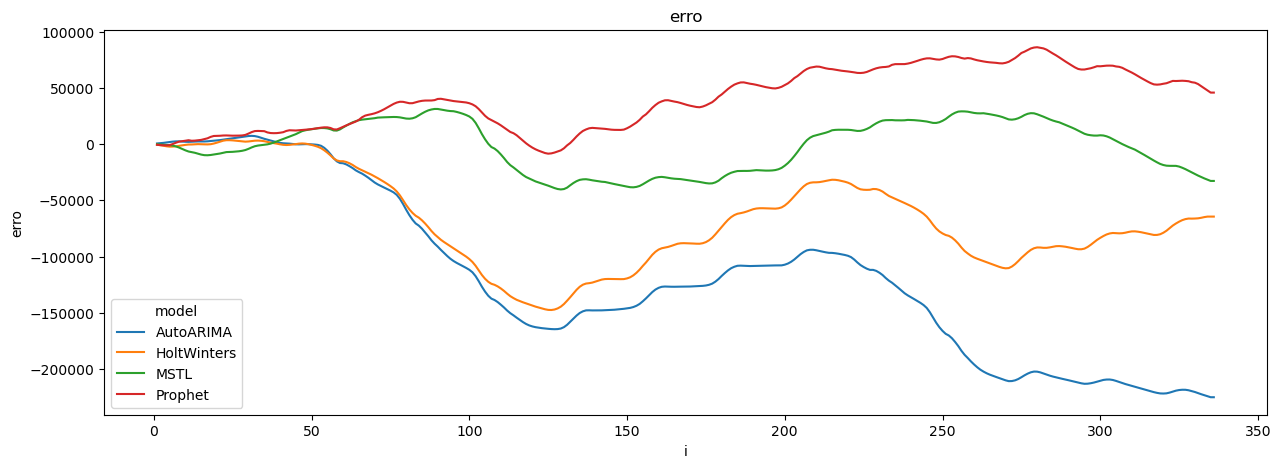

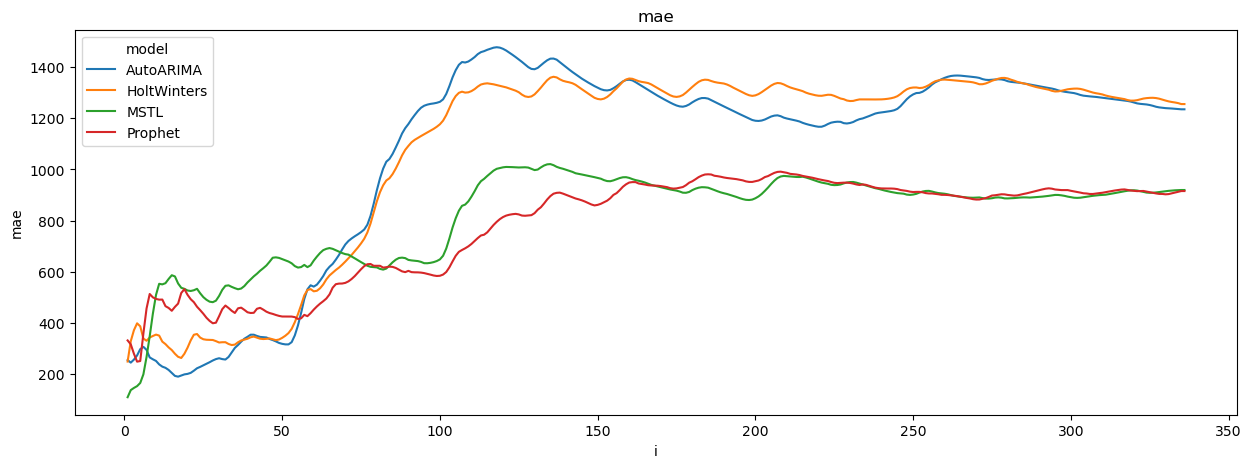

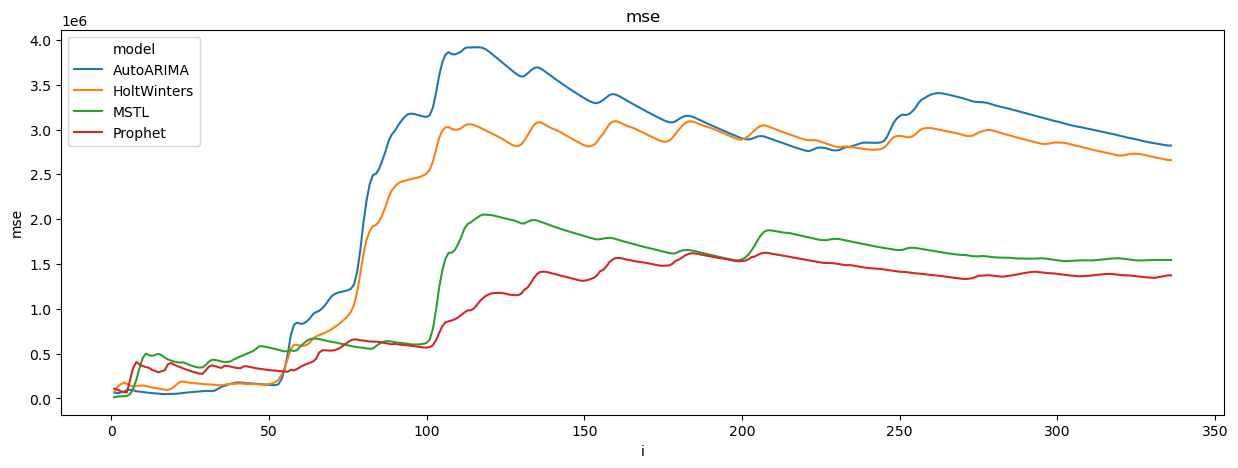

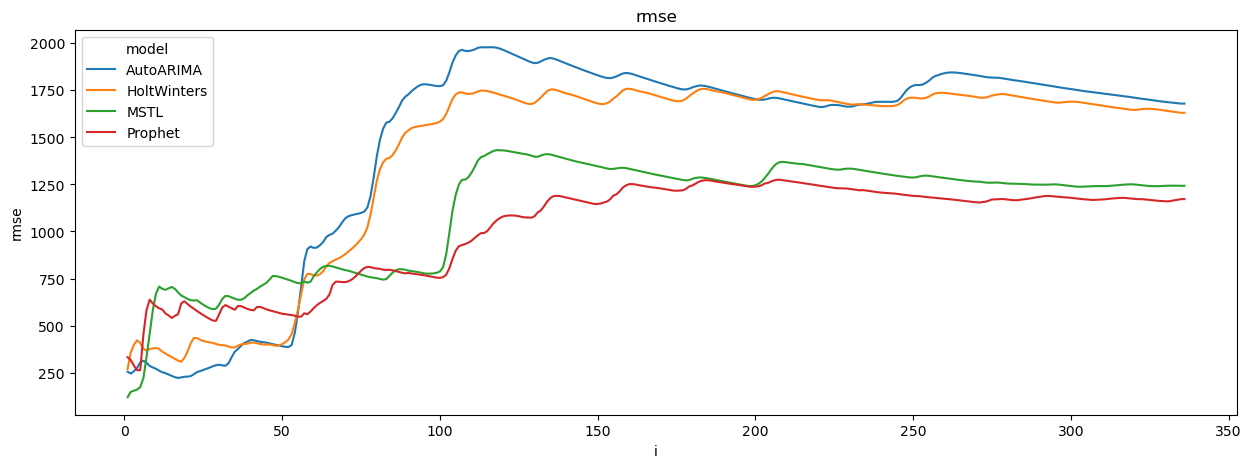

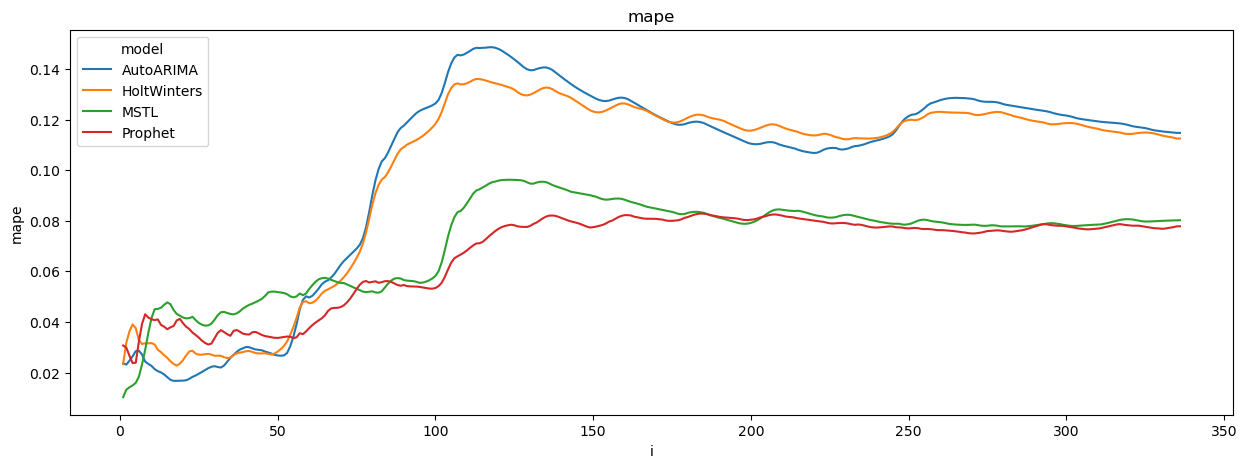

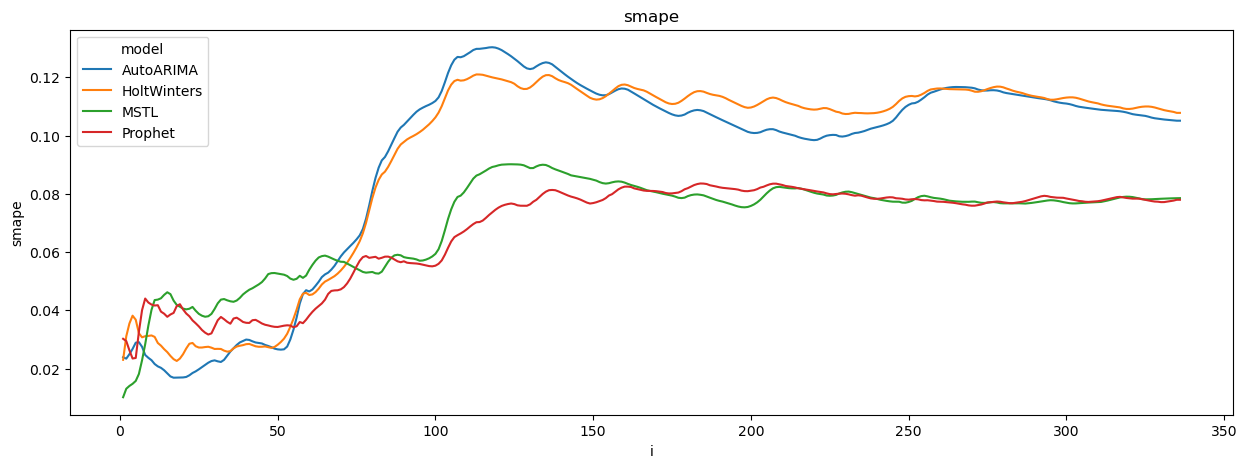

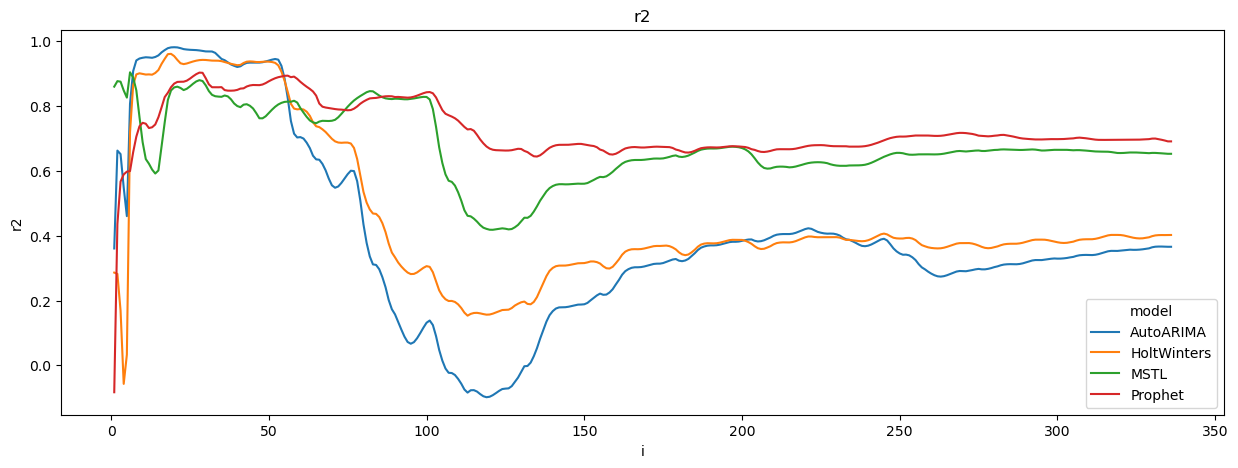

In [16]:
metrics = list(get_metrics(df_fc_test["yhat"], df_fc_test["y"]).keys())
for metric in metrics:
    plt.figure(figsize=(15,5))
    sns.lineplot(data=all_metrics, y=metric, x="i", hue="model")
    plt.title(metric)
    plt.show()

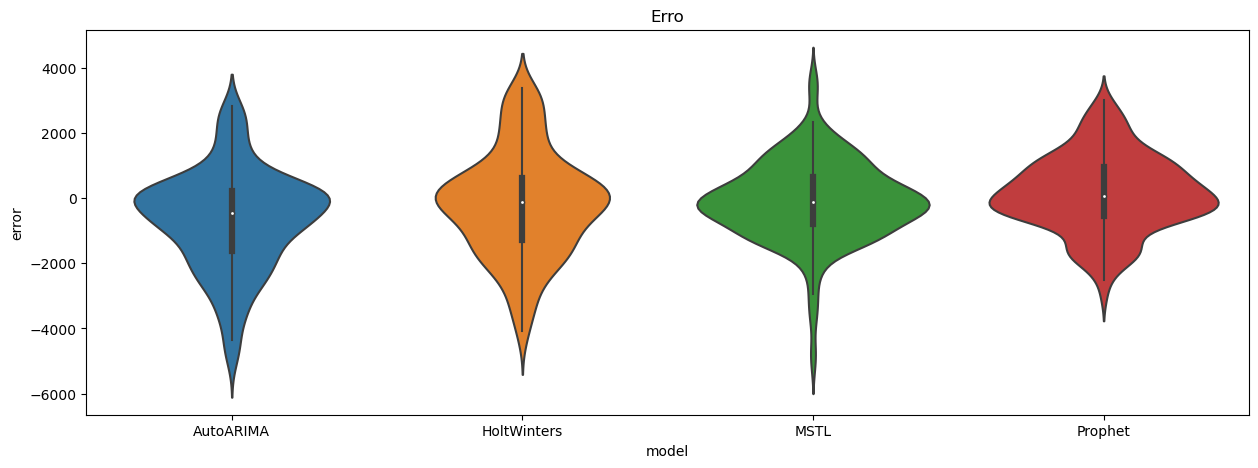

In [18]:
plt.figure(figsize=(15,5))
sns.violinplot(data=df_fc_test, x="model", y="error")
plt.title("Erro")
plt.show()

# Série tabular (tree models)

In [19]:
from utils.ts_wrangling import to_supervised_frame

In [22]:
train_series = train.loc[:,"load_mwmed"]

In [70]:
train["(t-1)"] = train_series.shift(1)
train.head()

C:\Users\user\AppData\Local\Temp\ipykernel_7256\279935669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["(t-1)"] = train_series.shift(1)


,id_reg,desc_reg,load_mwmed,(t-1)
date,,,,
2022-05-12 00:00:00,S,SUL,9589.093038,NaN
2022-05-12 01:00:00,S,SUL,8966.004979,9589.093038
2022-05-12 02:00:00,S,SUL,8566.040982,8966.004979
2022-05-12 03:00:00,S,SUL,8529.068013,8566.040982
2022-05-12 04:00:00,S,SUL,8661.126943,8529.068013


In [68]:
def to_supervised_frame(df: pd.DataFrame, 
                        y_col: str, 
                        n_in: int= 1, 
                        n_out: int=1, 
                        dropnan: bool=True) -> pd.DataFrame:
    """Função que transforma dados univariados para o formato tabular com base nos lags.

    Args:
        df (pd.DataFrame): _description_
        n_in (int, optional): _description_. Defaults to 1.
        n_out (int, optional): _description_. Defaults to 1.
        dropnan (bool, optional): _description_. Defaults to True.

    Returns:
        pd.DataFrame: _description_
    """
    series = df.loc[:,y_col]
    cols = []
    for i in range(n_in, 0, -1):
        lag = series.shift(i)
        lag.name = f"{y_col}(t-{i})"
        cols.append(lag)
    for i in range(0,n_out+1):
        lag = series.shift(i)
        lag.name = f"{y_col}(t+{i})"
        cols.append(lag)
    lags_df = pd.concat(cols, axis=1)
    if dropnan:
        lags_df.dropna(inplace=True)
    return lags_df

In [69]:
to_supervised_frame(train, "load_mwmed", n_in=3, n_out=3)

,load_mwmed(t-3),load_mwmed(t-2),load_mwmed(t-1),load_mwmed(t+0),load_mwmed(t+1),load_mwmed(t+2),load_mwmed(t+3)
date,,,,,,,
2022-05-12 03:00:00,9589.093038,8966.004979,8566.040982,8529.068013,8566.040982,8966.004979,9589.093038
2022-05-12 04:00:00,8966.004979,8566.040982,8529.068013,8661.126943,8529.068013,8566.040982,8966.004979
2022-05-12 05:00:00,8566.040982,8529.068013,8661.126943,9267.539000,8661.126943,8529.068013,8566.040982
2022-05-12 06:00:00,8529.068013,8661.126943,9267.539000,10623.842027,9267.539000,8661.126943,8529.068013
2022-05-12 07:00:00,8661.126943,9267.539000,10623.842027,11628.848004,10623.842027,9267.539000,8661.126943
...,...,...,...,...,...,...,...
2023-04-27 19:00:00,14124.374000,14672.592000,15705.449000,15488.721000,15705.449000,14672.592000,14124.374000
2023-04-27 20:00:00,14672.592000,15705.449000,15488.721000,14617.591000,15488.721000,15705.449000,14672.592000
2023-04-27 21:00:00,15705.449000,15488.721000,14617.591000,14154.210000,14617.591000,15488.721000,15705.449000
